## Training Neural Netwok for Energy Prediction

**Cognio_NeuralNetwork_Forecaster** used a pre-trained model to provide a 24-hour forecast for energy consumption

Before we use the forecasting custom function **Cognio_NeuralNetwork_Forecaster**, we need to 
 1. Train a NN model, and
 2. Save the NN model in the model store database 
 
This notebook provides a walk-through to complete the above two steps

### Step 1: Training

a. Load the available data <br>
b. Determine lenght of 24-hour prediction <br>
c. Build the feature vector for training <br>
We're using the following features for our model <br>


    Feature 1        kw_lag_24                Power consumption at the same time of the previous day
    Feature 2        temp_lag_24              Tempeature at the same time of the previous day
    Features 3-27    hour_0 to hour_23        Hour of the day, one hot encoded
    Features 28-34   weekday_0 to weekday_6   Day of week, one hot encoded
    
d. Setup up model and start training <br>
e. Add additional training information we need to save for the Forecastor <br>
f. Perform output analysis <br>
g. *(Optional)* save the trained  model
h. *(Optional)* retrieve a trained model


In [1]:
#Data structures
import pandas as pd
import numpy as np
import datetime as dt

#plotting
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

#Statistics
import math
import time
import scipy as sp
from sklearn import preprocessing, metrics
#Forecasting
import pyrenn as prn
#to disable warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#a. Load the available data into a dataframe

datapath='../data/IoTData.csv'
df = pd.read_csv(datapath, index_col=False, parse_dates=['DATETIME'])
df.head(5)

,DATETIME,TEMP_AIR,UMIDADE_REL,KW,KW2
0,2019-09-15 00:00:00,18.7,80.0,690.48,69.048
1,2019-09-15 01:00:00,18.2,83.0,685.44,68.544
2,2019-09-15 02:00:00,18.2,83.0,656.88,65.688
3,2019-09-15 03:00:00,18.2,83.0,655.20,65.520
4,2019-09-15 04:00:00,18.3,82.0,660.24,66.024


In [3]:
#b. this will determine how much data to leave out for validation
predict_days = 24 * 5

In [4]:
#c. Build feature vector for training

hour_categories = [f'hour_{n}' for n in range(24)]
weekday_categories = [f'weekday_{n}' for n in range(7)]
feature_vector = ['kw_lag_24', 'temp_lag_24']
feature_vector.extend(hour_categories)
feature_vector.extend(weekday_categories)

feature_vector

['kw_lag_24',
 'temp_lag_24',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6']

In [5]:
#helper functions to build features
#In this pipeline this is done using FeatureBuilder custom function

def day_lag(df, time_col, current_time, ret_col, lag=1):
    try:
        #iloc[0] makes empty series error out so we return np.nan
        return df[df[time_col] == current_time - dt.timedelta(days=lag)].iloc[0][ret_col]
    except:
        if isinstance(ret_col, str):
            return np.nan
        else:
            return [np.nan] * len(ret_col)

In [6]:
#building features from original df

df_nn_ = df[['DATETIME', 'KW', 'TEMP_AIR']] # need these three columns from original data to build all the features
df_nn = df_nn_.loc[1:]

#1 building feature 1, 2
df_nn.loc[:, ('kw_lag_24', 'temp_lag_24')] =  [day_lag(df_nn, 'DATETIME', df_nn.iloc[i]['DATETIME'], ['KW', 'TEMP_AIR']) for i in range(df_nn.shape[0])]
df_nn.dropna(inplace=True)

#2 building feature 3-27
df_nn.loc[:, ('hour_of_day')] = df_nn.DATETIME.dt.hour
#one hot encoding hour of day
enc_hour = preprocessing.OneHotEncoder()
enc_hour.fit(df_nn['hour_of_day'].values[:df_nn.shape[0] - predict_days].reshape(-1,1))
enc_hour_val = enc_hour.transform(df_nn['hour_of_day'].values.reshape(-1,1)).toarray()
df_nn.loc[:, tuple(hour_categories)] = enc_hour_val

#3 building feature 28-34
df_nn.loc[:, ('day_of_week')] = df_nn.DATETIME.dt.weekday
#one hot encoding day of week
enc_weekday = preprocessing.OneHotEncoder()
enc_weekday.fit(df_nn['day_of_week'].values[:df_nn.shape[0] - predict_days].reshape(-1,1))
enc_weekday_val = enc_weekday.transform(df_nn['day_of_week'].values.reshape(-1,1)).toarray()
df_nn.loc[:, tuple(weekday_categories)] = enc_weekday_val

In [7]:
#get the features ready for model
#performs data split for training and validation

train_up_to = df_nn.shape[0] - predict_days
X_train = df_nn[:train_up_to][feature_vector].T.to_numpy()
X_test = df_nn[:train_up_to]['KW'].values.reshape(-1, 1).T
Y_train = df_nn[train_up_to:][feature_vector].T.to_numpy()
Y_test = df_nn[train_up_to:]['KW'].values.reshape(-1, 1).T

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape, train_up_to, df_nn[:train_up_to].shape #sanity check the shapes of all features

((33, 8086), (1, 8086), (33, 120), (1, 120), 8086, (8086, 38))

In [8]:
#d. Setup up model and start training

net = prn.CreateNN([X_train.shape[0],4,4,X_test.shape[0]])

In [9]:
%%time
net = prn.train_LM(X_train,X_test,net,verbose=True,k_max=100,E_stop=1e1)

Iteration:  0 		Error:  7730.707690140376 	scale factor:  3.0
Iteration:  1 		Error:  261.55629068524496 	scale factor:  0.3
Iteration:  2 		Error:  152.2849980356166 	scale factor:  0.3
Iteration:  3 		Error:  105.89596676256373 	scale factor:  0.03
Iteration:  4 		Error:  92.02152849543275 	scale factor:  0.3
Iteration:  5 		Error:  86.82784509455286 	scale factor:  0.3
Iteration:  6 		Error:  86.03655689450433 	scale factor:  0.03
Iteration:  7 		Error:  85.39366408306155 	scale factor:  0.03
Iteration:  8 		Error:  83.49902741122715 	scale factor:  0.03
Iteration:  9 		Error:  83.08736772106826 	scale factor:  0.03
Iteration:  10 		Error:  82.91201312447382 	scale factor:  0.03
Iteration:  11 		Error:  82.62398924783554 	scale factor:  0.3
Iteration:  12 		Error:  82.57383887388849 	scale factor:  0.3
Iteration:  13 		Error:  82.52166879421425 	scale factor:  0.3
Iteration:  14 		Error:  82.46672172874639 	scale factor:  0.3
Iteration:  15 		Error:  82.4097922951056 	scale factor: 

In [11]:
#e. Add additional training information we need to save for the Forecastor

#save one hot encoders
net['OneHotEncoderHour'] = enc_hour
net['OneHotEncoderWeekday'] = enc_weekday

#save feature vectors
net['FeatureVector'] = feature_vector

In [12]:
# (Optional) Uncomment the line below to save the trained model
# save_nn_path = f'../output/NN_Forecastor_{time.strftime("%Y%m%d-%H%M%S")}.csv'
# prn.saveNN(net,save_nn_path)

In [ ]:
# (Optional) Uncomment the line below to retrieve a saved model
# path_to_model = save_nn_path
# net = prn.loadNN(save_nn_path)

#### Output Analysis

Do output analysis to test out the model before saving it in the db

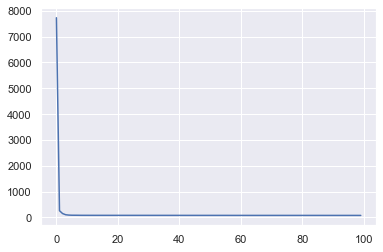

In [13]:
#plot training error
plt.plot(net['ErrorHistory'], label='Train Error')

In [14]:
#get training and validation prediction
y = prn.NNOut(X_train,net)
ytest = prn.NNOut(Y_train,net)

In [25]:
print(
f'Training Output error analysis\n\
r2_score: {metrics.r2_score(X_test.T, y)} \n\
RMSE: {math.sqrt(metrics.mean_squared_error(X_test.T, y))} \n\
MAE: {metrics.mean_absolute_error(X_test.T, y)}'
)
print()
print(
f'Test Output error analysis\n\
r2_score: {metrics.r2_score(Y_test.T, ytest)} \n\
RMSE: {math.sqrt(metrics.mean_squared_error(Y_test.T, ytest))} \n\
MAE: {metrics.mean_absolute_error(Y_test.T, ytest)}'
)

Training Output error analysis
r2_score: 0.6355441123410916 
RMSE: 93.56128652838171 
MAE: 70.1738273572133

Test Output error analysis
r2_score: 0.3936292422208817 
RMSE: 96.39935838001095 
MAE: 72.25454228236246


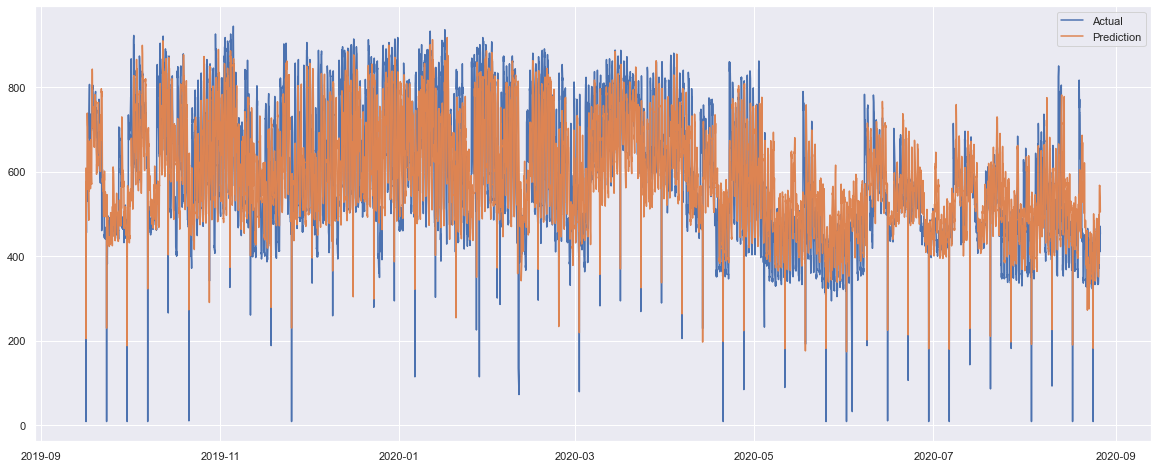

In [15]:
#plot training actual and prediction for visual analysis
plot_train = pd.DataFrame(df_nn[:train_up_to]['DATETIME'].values, columns=['DATETIME'])
plot_train['predicted_KW'] = y
plot_train['actual_KW'] = X_test.T
plot_train.set_index('DATETIME', inplace=True)

plt.figure(figsize=(20,8))
plt.plot(plot_train['actual_KW'], label="Actual")
plt.plot(plot_train['predicted_KW'], label="Prediction")
plt.legend(loc = 'best')

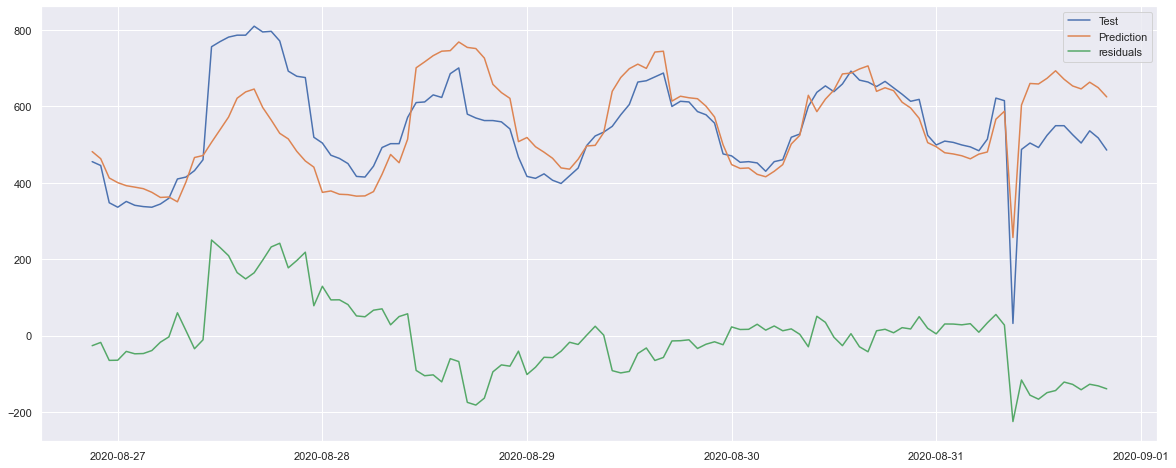

In [16]:
#plot testing actual and prediction for visual analysis
plot_test = pd.DataFrame(df_nn[train_up_to:]['DATETIME'].values, columns=['DATETIME'])
plot_test['predicted_KW'] = ytest
plot_test['actual_KW'] = Y_test.T
plot_test['residuals'] = plot_test['actual_KW'] - plot_test['predicted_KW']
plot_test.set_index('DATETIME', inplace=True)

plt.figure(figsize=(20,8))
plt.plot(plot_test['actual_KW'], label="Test")
plt.plot(plot_test['predicted_KW'], label="Prediction")
plt.plot(plot_test['residuals'], label="residuals")
plt.legend(loc = 'best')

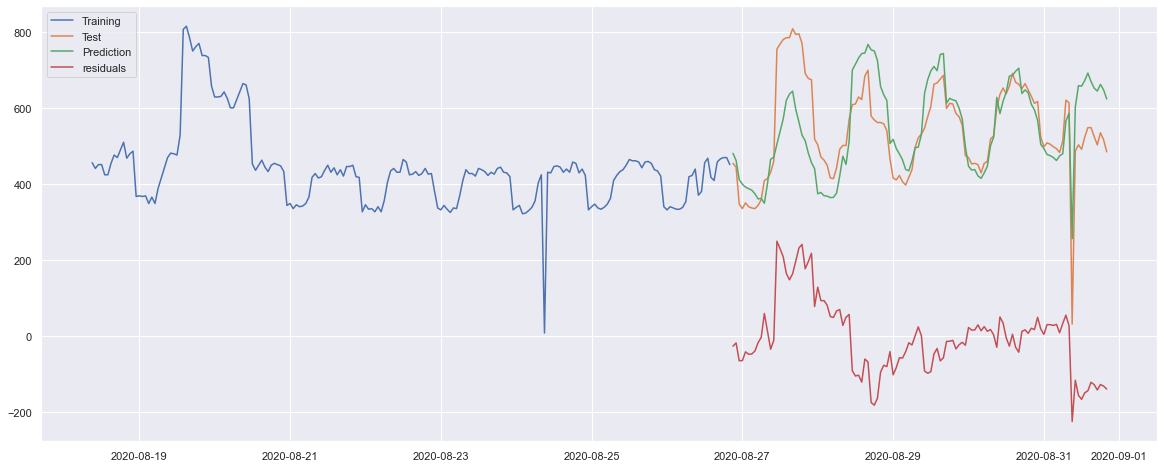

In [17]:
#plot everything together 
plt.figure(figsize=(20,8))
plt.plot(plot_train['actual_KW'][-200:], label="Training")
plt.plot(plot_test['actual_KW'], label="Test")
plt.plot(plot_test['predicted_KW'], label="Prediction")
plt.plot(plot_test['residuals'], label="residuals")
plt.legend(loc = 'best')
plt.show()

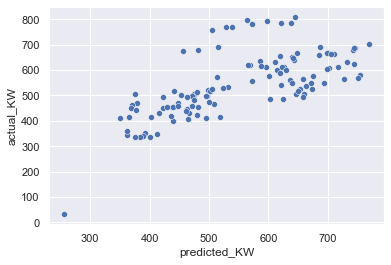

In [18]:
#correlation between predicted and actual KW in validation data
plot_size = (5, 5)
sns.scatterplot(x='predicted_KW', y='actual_KW', data=plot_test)

### Step 2: Saving the model

Currently we are saving the model for an entity type under the assumption that all entities will use the same model. This architecture will be fixed in furture versions <br>
You can register the same model for different entity types by running this part of the notebook multiple times and chaning the *entity_type* field

a. determine a model name <br>
b. load tenant credentials <br>
c. connect to the database <br>
d. store model <br>
e. test storing model by retrieving it <br>
f. *(Optional)* delete the model if you want to chage the name, re-train, other reasons

In [19]:
# a. pick a model name (the most important part)
# well need this name for the Cognio_NeuralNetwork_Forecaster custom function
# Sprcify the entity type you are registering this model for
entity_type = 'demand4'
model_name  = 'Cognio_Neural_Netwok_Forecastor' + '_' + entity_type

In [21]:
#b. load the credentials
#The path to credential file is relative to this notebook

cedential_path = '../dev_resources/cognio.json'
import json
from iotfunctions.db import Database

with open(cedential_path, encoding='utf-8') as F:
    credentials = json.loads(F.read())

In [22]:
#c. connect to the database with the entity type we're registering the model for

db = Database(credentials=credentials, entity_type=entity_type)

In [23]:
db.model_store.store_model(model_name, net)

In [24]:
# test the model was saved correctly by accessing it

db.model_store.retrieve_model(model_name)

{'delay': {'In': [0], 'Intern': [], 'Out': []},
 'nn': [33, 4, 4, 1],
 'M': 3,
 'layers': [4, 4, 1],
 'dmax': 0,
 'U': [3],
 'X': [1],
 'dL': {(1, 1): [],
  (1, 2): [],
  (1, 3): [],
  (2, 1): [0],
  (2, 2): [],
  (2, 3): [],
  (3, 2): [0],
  (3, 3): []},
 'dI': {(1, 1): [0]},
 'L_b': {1: [2], 2: [3], 3: []},
 'L_f': {1: [], 2: [1], 3: [2]},
 'I': {1: [1]},
 'CX_LW': {3: []},
 'CU_LW': {1: [], 2: [], 3: []},
 'w0': array([-0.22598923, -0.26930534,  0.08884634,  0.18162057, -0.19477264,
         0.18293338,  0.30068419, -0.23929369,  0.08399862,  0.06688   ,
         0.10940228, -0.21282338,  0.31075942,  0.44984641,  0.22135702,
        -0.05661338, -0.13052062,  0.41199734,  0.40179268,  0.23548193,
         0.00934133, -0.00626758, -0.08240009,  0.23418522, -0.08597957,
        -0.01776522,  0.02471192,  0.22726559, -0.45287929, -0.30896967,
         0.05913582, -0.22024552,  0.32410646, -0.08622274,  0.37272141,
         0.48546473, -0.01524064,  0.1678498 ,  0.13036043, -0.07192854

In [ ]:
#if you want to delete the above model you can uncomment the line below and run the cell
#db.model_store.delete_model(model_name)

### Step 3: Using the Cognio_NeuralNetwork_Forecaster

**From the dashboard** <br>
a. Use the ForecastBuilder custom function to create `kw_lag_24` and `temp_lag_24` calculated metrics for entity_type=demand4 (replace with entity type you are workng with) <br>
b. [Cognio_NeuralNetwork_Forecaster](https://github.com/singhshraddha/custom-functions/blob/development/custom/forecast.py) is a cutom function pre-registered with Cognio tenant. Follow these steps to get the predictions on the UI <br>
&emsp;b.1 Choose `Cognio_NeuralNetwork_Forecaster` custom function from the catalog <br>
&emsp;b.2 Set saved_model_name parameter to `Cognio_Neural_Netwok_Forecastor_demand4` (replace with entity_type's model) <br>
&emsp;b.2 Select `kw_lag_24` and `temp_lag_24` as the features parameter from the drop down <br>
&emsp;b.3 Specify the target/output name <br>